In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [4]:
import os

os.chdir('/Users/madsbirch/Documents/4_semester/mlops/mlops-sentiment-analysis')
print("Current working directory: {0}".format(os.getcwd()))

import gzip, json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

from transformers import BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer

from src.data.AmazonReviewData import AmazonReviewsDataset
from src.data.make_dataset import get_pandas_DF, sentiment_map, preprocess_data, get_dataloaders

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Set device (mps is specific to mac with M1 processor)
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# path to raw data
raw_data_path = "data/raw/"


Current working directory: /Users/madsbirch/Documents/4_semester/mlops/mlops-sentiment-analysis


ImportError: cannot import name 'get_dataloaders' from 'src.data.make_dataset' (/Users/madsbirch/Documents/4_semester/mlops/mlops-sentiment-analysis/src/data/make_dataset.py)

### 1 Data exporation

The data can be downloaded from: http://jmcauley.ucsd.edu/data/amazon/links.html

In [5]:
df = get_pandas_DF(raw_data_path+'reviews_Automotive_5.json.gz')
# subset columns and rename to more intuitive names 
df = df[['overall', 'reviewText']]
df = df.rename(columns={'overall': 'sentiment', 'reviewText': 'review'})
  
# do sentiment mapping
df.sentiment = df.sentiment.apply(sentiment_map)
df.head()

,sentiment,review
0,2,I needed a set of jumper cables for my new car...
1,2,"These long cables work fine for my truck, but ..."
2,2,Can't comment much on these since they have no...
3,2,I absolutley love Amazon!!! For the price of ...
4,2,I purchased the 12' feet long cable set and th...


Classes are highly imbalanced!

In [6]:
df.sentiment.value_counts()

2    17895
1     1430
0     1148
Name: sentiment, dtype: int64

### Train model

In [7]:
train_loader, test_loader = get_dataloaders(batch_size = 12, max_len =20,num_workers = 0)

In [8]:
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# testing the model

for batch in train_loader:
    review = batch['review']
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    
    out = model(input_ids, attention_mask)
    pooled_out = out['pooler_output']
    break

In [18]:
pooled_out

tensor([[-0.7168, -0.1963, -0.3980,  ..., -0.3319, -0.4440,  0.6657],
        [-0.7973, -0.2976, -0.1281,  ...,  0.0212, -0.6148,  0.8669],
        [-0.7970, -0.1884, -0.0733,  ..., -0.3134, -0.5340,  0.7970],
        ...,
        [-0.7437, -0.2450, -0.1822,  ..., -0.0411, -0.4481,  0.8011],
        [-0.7603, -0.2928, -0.1148,  ...,  0.0521, -0.5397,  0.7908],
        [-0.7803, -0.2226, -0.5341,  ..., -0.5093, -0.4235,  0.7299]],
       grad_fn=<TanhBackward0>)

##### MODEL INFO

A description of the BERT model can be found at: https://huggingface.co/bert-base-uncased

We use the uncased model, which does not differ between Mads and mads (capital letters are ignored.)

It would be nice exploring how to download smaller pretrained BERT-models as discussed in this articel (https://arxiv.org/abs/1908.08962), as those would be trainable locally. The smaller models mentioned in the article are available at: https://github.com/google-research/bert/



In [19]:
class BertSentiment(nn.Module):
  def __init__(self, n_classes: int, dropout: float, bert_out_dim = 768):
    super(BertSentiment, self).__init__()
    self.bert = BertModel.from_pretrained("bert-base-uncased")
    self.dropout = nn.Dropout(dropout)
    self.output = nn.Linear(bert_out_dim, n_classes)

  def forward(self, input_ids, attention_mask):
    output = self.bert(input_ids, attention_mask)
    pooled_output = output['pooler_output']
    x = self.dropout(pooled_output)
    out = self.output(x)
    
    return out

### NOT USED AND NOT WORKING. IF WE WANT TO USE THE OUTPUT OF THE MODEL NEEDS TO BE POOLED SOMEHOW ###
class DistilBertSentiment(nn.Module):
  def __init__(self, n_classes: int, dropout: float, bert_out_dim = 3072):
    super(DistilBertSentiment, self).__init__()
    self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
    self.dropout = nn.Dropout(dropout)
    self.output = nn.Linear(bert_out_dim, n_classes)

  def forward(self, input_ids, attention_mask):
    output = self.bert(input_ids, attention_mask)
    pooled_output = output['pooler_output']
    x = self.dropout(pooled_output)
    out = self.output(x)
    
    return out


In [22]:
# get data loader
train_loader, test_loader = get_dataloaders(max_len = 20, batch_size = 12, num_workers = 0)

# init model
model = BertSentiment(n_classes=3, dropout=0.2).to(device)

# training params
num_epochs = 5
lr = 1e-3

# define criterion and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
# BASIC TRAINNIG LOOP

LOSS_LIST = []

for e in range(num_epochs):
  print(f'[EPOCH]: {e+1:3d}')
  
  train_loss = 0
  model.train()
  for batch in tqdm(train_loader):
    
    optimizer.zero_grad()
    
    # move data to device
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    
    # get model outout and calc loss
    output = model(input_ids, attention_mask)
    loss = loss_fn(output, labels)
    train_loss += loss.item()
    
    loss.backward()
    optimizer.step()
  
  train_loss_epoch = train_loss/len(train_loader)
  LOSS_LIST.append(train_loss_epoch)


[EPOCH]:   1


100%|██████████| 1195/1195 [07:12<00:00,  2.77it/s]


[EPOCH]:   2


100%|██████████| 1195/1195 [07:13<00:00,  2.76it/s]


[EPOCH]:   3


100%|██████████| 1195/1195 [07:15<00:00,  2.74it/s]


[EPOCH]:   4


100%|██████████| 1195/1195 [07:16<00:00,  2.73it/s]


[EPOCH]:   5


100%|██████████| 1195/1195 [07:12<00:00,  2.76it/s]


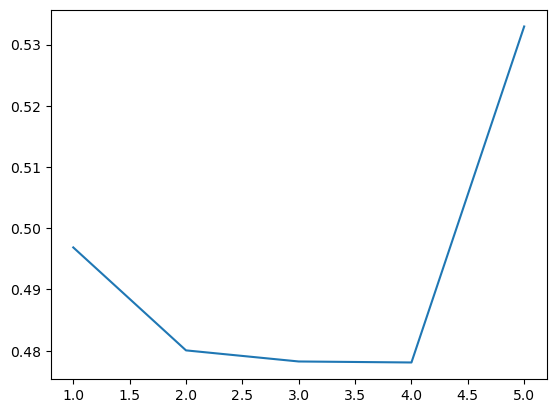

In [24]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1,num_epochs+1, dtype=int),LOSS_LIST)

### Testing model

#### Test model on single samples

In [27]:
### TEST MODEL ON SPECIFIC SAMPLES FROM TEST SET ###

# pick smaple ID:
test_id = 111

# define tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_df, test_df, _, _ = preprocess_data(raw_data_path, tokenizer)

# get test sample
test_review = test_df['review'].iloc[test_id]
original_label = test_df['sentiment'].iloc[test_id]

# encode sample
encoding = tokenizer.encode_plus(
    test_review,
    add_special_tokens=True,
    max_length=256,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

print(f'[REVIEW]: {test_review}')
print(f'[LABEL]: {original_label}')

# get prediction for sample
with torch.no_grad():
  model.to('cpu')
  
  input_ids = encoding['input_ids'].to('cpu')
  attention_mask = encoding['attention_mask'].to('cpu')
  
  preds = model(input_ids, attention_mask)
  preds = torch.argmax(F.softmax(preds, dim = 1)).detach().numpy()
  print(f'[PREDICTED LABEL]: {preds}')

[REVIEW]: My car: 2004 Honda (Acura) TLI've installed these on the rear blinkers. For blinker applications, load resistors are often required and I've installed them. These bulbs are not much brighter than traditional incandescent bulbs but do look nice. The socket was not an exact match for the 7440 bulbs, so I had to modify the socket and had to solder the terminals directly onto the socket, which I do not recommend unless you're skilled in soldering.
[LABEL]: 2
[PREDICTED LABEL]: 2


#### Test model on entire test set

In [28]:
def test(model, testloader, display=True):
    model.eval().to('cpu')
    
    test_loss = 0
    n_correct = 0
    total = 0
    
    loss_fn = nn.CrossEntropyLoss()
    
    TEST_ACC = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            
            review = batch['review']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            
            outputs = model(input_ids, attention_mask)
            
            preds = torch.argmax(F.softmax(outputs, dim = 1),dim=1)
            n_correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = (n_correct/total)*100
    
    if display:
        print(f'Accuracy on the test set: {acc:.2f} %')
    
    return

In [29]:
test(model, test_loader)

100%|██████████| 512/512 [00:54<00:00,  9.45it/s]

Accuracy on the test set: 87.82 %
